In [13]:
import numpy as np
import torch
import torch.nn as nn 
import torch.optim as optim
import random
import pandas as pd
import matplotlib.pyplot as plt

Data Generator

In [14]:
matrix_T = np.array([[0, 1], [1, 0]])
matrix_U = np.array([[1, -1], [0, 1]])

inverse_T = np.array([[0, 1], [1, 0]])
inverse_U = np.array([[1, 1], [0, 1]])

def data_generator(num_points):
    data = []
    max_moves = 30
    end_position = np.array([[1,0]]) 
    last_move = 3
    for i in range(num_points):
        current_position = end_position
        moves = random.randint(1, max_moves)
        for q in range(moves):
            coin = random.randint(0,1)
            if coin == 0: 
                current_position = current_position @ inverse_T
                last_move = 0 
                if q != (moves-1):
                    current_position = current_position @ inverse_U
                    last_move = 1
            if coin == 1: 
                current_position = current_position @ inverse_U 
                last_move = 1
        current_position = np.append(current_position, last_move)
        data.append(current_position.tolist())
    return data

Turn to CSV using Pandas

In [15]:
data_pd = pd.DataFrame(data_generator(20000))
data_pd.to_csv("generated_pairs.csv", index = False)

Turn CSV file to tensor

In [16]:
data = pd.read_csv("generated_pairs.csv", names=["0","1","2"], delimiter=",")
dataset = torch.utils.data.TensorDataset(
    torch.tensor(data.loc[:, "0":"1"].values,dtype=torch.float32), # input 
    torch.tensor(data.loc[:, ["2"]].values, dtype = torch.float32) #output 
)
X, Y = dataset[:] #label input and output 

Make the Model

In [17]:
#https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step 
model = nn.Sequential(
    nn.Linear(2, 128), #first layer 128
    nn.ReLU(),
    nn.Linear(128,64), #second layer 64
    nn.ReLU(),
    nn.Linear(64, 16), #third layer 16
    nn.ReLU(),
    nn.Linear(16,1), #singular output 
    nn.Sigmoid()
)

for name, param in model.named_parameters():
    print(f"Layer: {name}, Data Type: {param.dtype}")

loss_function = nn.BCELoss() #should this be our loss function too? 
optimizer = optim.Adam(model.parameters(), lr = 0.02) #chose Adam and lr from site 

Layer: 0.weight, Data Type: torch.float32
Layer: 0.bias, Data Type: torch.float32
Layer: 2.weight, Data Type: torch.float32
Layer: 2.bias, Data Type: torch.float32
Layer: 4.weight, Data Type: torch.float32
Layer: 4.bias, Data Type: torch.float32
Layer: 6.weight, Data Type: torch.float32
Layer: 6.bias, Data Type: torch.float32


Training Model

In [30]:
num_epochs = 200
num_batches = 10 

In [31]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()
        X_batch = X[i:i+num_batches]
        # print(X_batch)
        y_pred = model(torch.Tensor(X_batch))
        Y_batch = Y[i:i+num_batches]
        # print(Y_batch)
        loss = loss_function(y_pred, torch.Tensor(Y_batch))
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    print(f'Finished epoch {epoch}, latest loss {-total_loss / len(data)}')

Finished epoch 0, latest loss 0.0004999750012499339
Finished epoch 1, latest loss 0.0004999750012499339
Finished epoch 2, latest loss 0.0004999750012499339
Finished epoch 3, latest loss 0.0004999750012499339
Finished epoch 4, latest loss 0.0004999750012499339
Finished epoch 5, latest loss 0.0004999750012499339
Finished epoch 6, latest loss 0.0004999750012499339
Finished epoch 7, latest loss 0.0004999750012499339
Finished epoch 8, latest loss 0.0004999750012499339
Finished epoch 9, latest loss 0.0004999750012499339
Finished epoch 10, latest loss 0.0004999750012499339
Finished epoch 11, latest loss 0.0004999750012499339
Finished epoch 12, latest loss 0.0004999750012499339
Finished epoch 13, latest loss 0.0004999750012499339
Finished epoch 14, latest loss 0.0004999750012499339
Finished epoch 15, latest loss 0.0004999750012499339
Finished epoch 16, latest loss 0.0004999750012499339
Finished epoch 17, latest loss 0.0004999750012499339
Finished epoch 18, latest loss 0.0004999750012499339
Fin

In [48]:
def euclidean_algorithm(pair): 
    a = pair[0]
    b = pair[1]
    plt.plot(a.detach(), b.detach(), "bo", markersize = 3)
    index = 1
    old_matrix = matrix_U

    
    while index < 500: 
        
        index += 1
        if a==0 or b==0: 
            return
        pred = model(torch.tensor([[a,b]]))
        if abs(1-pred) < abs(pred): # if prediciton is closer to 1 
            pair = pair @ matrix_U
            old_matrix = matrix_U
        else: 
            # if we ever hit 'pair' with matrix_T twice, then we've hit a loop, so break
            if bool(np.ndarray.all(old_matrix == matrix_T)):
                return
            pair = pair @ matrix_T
            old_matrix = matrix_T
        print(pair)
        a = float(pair[0])
        b = float(pair[1])
        plt.plot(a, b, "ro", markersize = 3+(index*.01)) #from cs544 notes 

tensor([10353., 57970.], dtype=torch.float64)
tensor([10353., 47617.], dtype=torch.float64)
tensor([10353., 37264.], dtype=torch.float64)
tensor([10353., 26911.], dtype=torch.float64)
tensor([10353., 16558.], dtype=torch.float64)
tensor([10353.,  6205.], dtype=torch.float64)
tensor([ 6205., 10353.], dtype=torch.float64)
tensor([6205., 4148.], dtype=torch.float64)
tensor([4148., 6205.], dtype=torch.float64)
tensor([4148., 2057.], dtype=torch.float64)
tensor([2057., 4148.], dtype=torch.float64)
tensor([2057., 2091.], dtype=torch.float64)
tensor([2057.,   34.], dtype=torch.float64)
tensor([  34., 2057.], dtype=torch.float64)
tensor([  34., 2023.], dtype=torch.float64)
tensor([  34., 1989.], dtype=torch.float64)
tensor([  34., 1955.], dtype=torch.float64)
tensor([  34., 1921.], dtype=torch.float64)
tensor([  34., 1887.], dtype=torch.float64)
tensor([  34., 1853.], dtype=torch.float64)
tensor([  34., 1819.], dtype=torch.float64)
tensor([  34., 1785.], dtype=torch.float64)
tensor([  34., 175

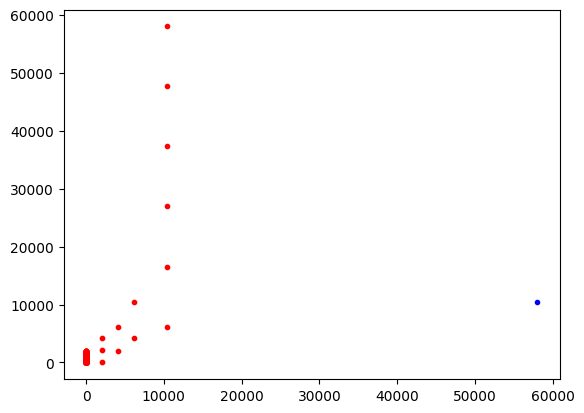

In [49]:
pair = torch.tensor([57970, 10353], dtype=torch.float32)
print(euclidean_algorithm(pair))